# Feature Transformation CheatSheet

Dataset [GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv](https://data.world/data-society/global-climate-change-data#) represents Global Climate Change Data from 1750－2015.

In [2]:
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
from collections import ChainMap
from sklearn.cluster import KMeans
from pyproj import Proj, Transformer
from google_trans_new import google_translator  
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,5)})

In [3]:
df = pd.read_csv('GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv')
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W
...,...,...,...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E


In [4]:
df.duplicated().any()

False

In [5]:
# check overall stats on your dataset
def show_stats(df):
    print(df.describe())
    for column in list(df.columns):
        print(column, '| Data type: ', df[column].dtype, '| Null values: ', df[column].isnull().sum(), round(df[column].isnull().sum()/len(df)*100, 2), '%', '| Numer of unique values: ',  len(np.unique(list(df[column].astype(str)))))
        print()

In [6]:
show_stats(df)

       AverageTemperature  AverageTemperatureUncertainty
count       228175.000000                  228175.000000
mean            18.125969                       0.969343
std             10.024800                       0.979644
min            -26.772000                       0.040000
25%             12.710000                       0.340000
50%             20.428000                       0.592000
75%             25.918000                       1.320000
max             38.283000                      14.037000
dt | Data type:  object | Null values:  0 0.0 % | Numer of unique values:  3239

AverageTemperature | Data type:  float64 | Null values:  11002 4.6 % | Numer of unique values:  56349

AverageTemperatureUncertainty | Data type:  float64 | Null values:  11002 4.6 % | Numer of unique values:  6270

City | Data type:  object | Null values:  0 0.0 % | Numer of unique values:  100

Country | Data type:  object | Null values:  0 0.0 % | Numer of unique values:  49

Latitude | Data type:  o

## Imputation of missing values
As is observed "AverageTemperature" and "AverageTemperatureUncertainty" columns are the only two numerical columns in the dataset and they have null values*. Here are few ideas how to fix null values:

Check if there are outliers:

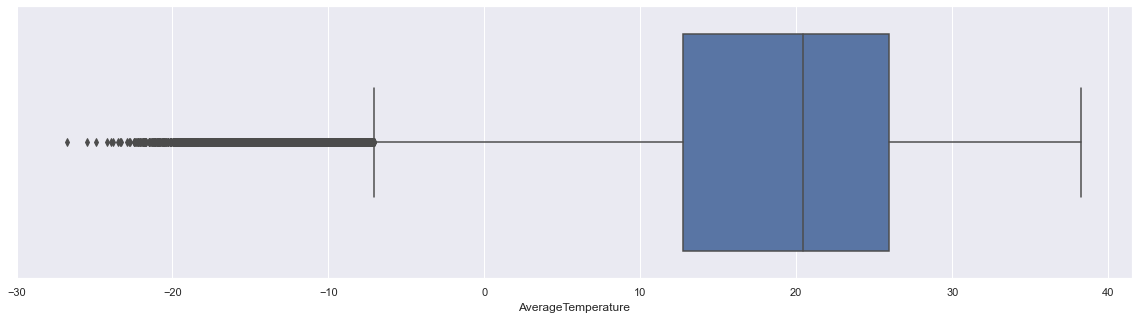

In [7]:
df['date'] = pd.to_datetime(df['dt'])
ax = sns.boxplot(x=df.index, data=df['AverageTemperature'])

In [8]:
# with mean
#df['AverageTemperature'] = df['AverageTemperature'].fillna(df['AverageTemperature'].mean())

# with median
df['AverageTemperature'] = df['AverageTemperature'].fillna(df['AverageTemperature'].median())

# with most frequent (mode)
#df['AverageTemperature'] = df['AverageTemperature'].fillna(df['AverageTemperature'].value_counts().index[0])

# with zero
#df['AverageTemperature'] = df['AverageTemperature'].fillna(0)

# with any value that much different from existed temperatures 
#df['AverageTemperature'] = df['AverageTemperature'].fillna(500)

# with predicted values
# XGBoost or similar models can be used to predict null values.

# do nothing or drop records with nulls
# Sometimes missing values are not applicable and imputing them is meaningless.

*use MissingIndicator to spot most types of missing values

AverageTemperature fluctuation over years:

<AxesSubplot:xlabel='date', ylabel='AverageTemperature'>

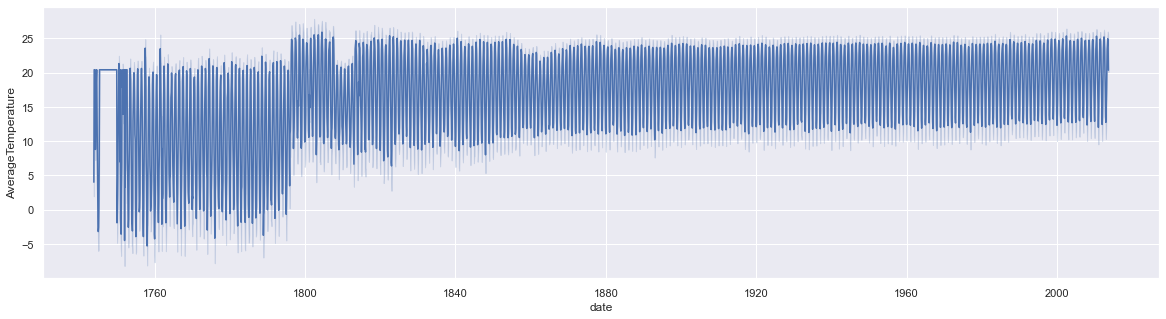

In [9]:
sns.lineplot(x=df['date'], y=df["AverageTemperature"])

## Transforming numerical features
You may want to transform feature to new format. Here are several ways to do so with such continous numerical feature as AverageTemperature:

In [10]:
# floats to int
df['AverageTemperature_int'] = df['AverageTemperature'].astype(int)

# round numbers
df['AverageTemperature_rounded'] = df['AverageTemperature'].round(1)

# scale with MinMaxScaler
scaler = MinMaxScaler()
df['AverageTemperature_minmax'] = scaler.fit_transform(df[['AverageTemperature']])

# scale with StandardScaler
scaler = StandardScaler()
df['AverageTemperature_standard'] = scaler.fit_transform(df[['AverageTemperature']])

# kmeans **
kmeans = KMeans(n_clusters=10, random_state=0).fit(df[['AverageTemperature']])
df['AverageTemperature_kmeans'] = kmeans.labels_

# kbins **
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
est.fit(df[['AverageTemperature']])
df['AverageTemperature_kbins'] = est.transform(df[['AverageTemperature']])

# log transformation
max_negative = abs(min(df['AverageTemperature']))
df['AverageTemperature_log'] = df['AverageTemperature'].apply(lambda x: x + max_negative + 0.001).replace(0, 0.001)
df["AverageTemperature_log"] = np.log(df['AverageTemperature_log'])

** use Silhouette Coefficient or Elbow method to estime the optimum number of clusters

/Users/asya/opt/anaconda3/envs/ml38/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/asya/opt/anaconda3/envs/ml38/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


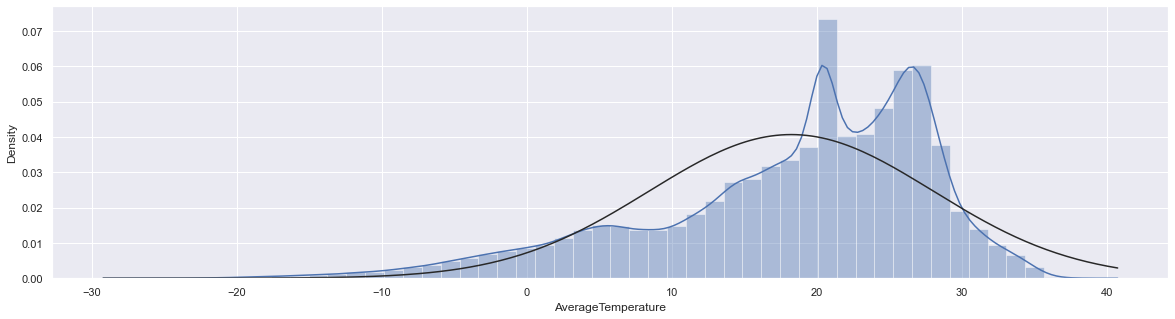

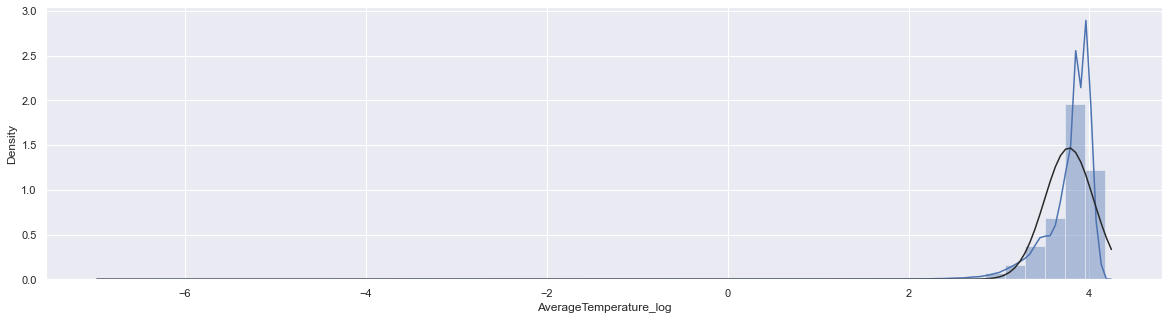

<Figure size 1440x360 with 0 Axes>

In [11]:
sns.distplot(df["AverageTemperature"], fit=stats.norm)
fig = plt.figure()
sns.distplot(df["AverageTemperature_log"], fit=stats.norm)
fig = plt.figure()

Then you might want to continue working with this kmeans transformation, for example, to encode it or to create more discrete values range, it can be done by:

In [12]:
# onehotencoder (get dummies)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['AverageTemperature_kbins']])
col_names = ['AverageTemperature_' + str(i) for i in range(len(np.unique(df['AverageTemperature_kbins'])))]
df[col_names] = enc.transform(df[['AverageTemperature_kbins']]).toarray()

# binary
df['AverageTemperature_hot_cold'] = df['AverageTemperature'].apply(lambda x: 'hot' if x > 10 else 'cold')

In [13]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,date,AverageTemperature_int,AverageTemperature_rounded,...,AverageTemperature_1,AverageTemperature_2,AverageTemperature_3,AverageTemperature_4,AverageTemperature_5,AverageTemperature_6,AverageTemperature_7,AverageTemperature_8,AverageTemperature_9,AverageTemperature_hot_cold
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-01-01,26,26.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-02-01,27,27.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-03-01,28,28.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-04-01,26,26.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-05-01,25,25.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E,2013-05-01,18,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E,2013-06-01,23,23.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E,2013-07-01,25,25.3,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E,2013-08-01,24,24.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot


## Datetime feature transformations

There is also a common datetime type of feature that can be transformed in different ways.

### Date

In [14]:
# number of month in a year
df['month_of_year'] = df['date'].dt.month

# number of week in the year
df['week_of_year'] = df['date'].dt.week

# number of the day in the week ***
df['day_of_year'] = df['date'].dt.dayofyear

# season ***
def get_season(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='01/03/'+year, end='31/05/'+year),
               'summer': pd.date_range(start='01/06/'+year, end='31/08/'+year),
               'autumn': pd.date_range(start='01/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'
df['season'] = df.date.map(get_season)

# day of the week ***
df['day_of_week'] = df['date'].dt.day_name()

# weekends ***
df['weekend'] = df['date'].dt.dayofweek

# holidays ***
cal = calendar()
holidays = cal.holidays(start=df['date'].min(), end=df['date'].max())
df['holiday'] = df['date'].isin(holidays)


<ipython-input-14-8c0ca05325d3>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = df['date'].dt.week


*** day of week, seasons, weekends and holidays vary in different hemispheres and countries 

### Time

Lets generate sample times to observe possible transformations:

In [15]:
times = pd.datetime.now().replace(microsecond=0)
df['time'] = pd.Series(pd.date_range(times, periods = len(df) , freq='37T')).dt.time

<ipython-input-15-e742f7cef45f>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  times = pd.datetime.now().replace(microsecond=0)


In [16]:
# hour
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour

# part of day
df['part_of_day'] = (df['hour'] % 24 + 4) // 4
df['part_of_day'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

# total minutes
df['minute'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.minute + (df['hour'] * 60)

# time to sin/cos
minutes = 24*60
df['sin'] = np.sin(2*np.pi*df['minute']/minutes)
df['cos'] = np.cos(2*np.pi*df['minute']/minutes)


In [17]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,date,AverageTemperature_int,AverageTemperature_rounded,...,season,day_of_week,weekend,holiday,time,hour,part_of_day,minute,sin,cos
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-01-01,26,26.7,...,winter,Monday,0,True,20:36:51,20,Night,1236,-0.777146,6.293204e-01
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-02-01,27,27.4,...,spring,Thursday,3,False,21:13:51,21,Night,1273,-0.665882,7.460574e-01
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-03-01,28,28.1,...,spring,Thursday,3,False,21:50:51,21,Night,1310,-0.537300,8.433914e-01
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-04-01,26,26.1,...,spring,Sunday,6,False,22:27:51,22,Night,1347,-0.394744,9.187912e-01
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-05-01,25,25.4,...,spring,Tuesday,1,False,23:04:51,23,Night,1384,-0.241922,9.702957e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E,2013-05-01,18,19.0,...,spring,Wednesday,2,False,06:00:51,6,Early Morning,360,1.000000,6.123234e-17
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E,2013-06-01,23,23.5,...,summer,Saturday,5,False,06:37:51,6,Early Morning,397,0.986996,-1.607426e-01
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E,2013-07-01,25,25.3,...,summer,Monday,0,False,07:14:51,7,Early Morning,434,0.948324,-3.173047e-01
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E,2013-08-01,24,24.5,...,summer,Thursday,3,False,07:51:51,7,Early Morning,471,0.884988,-4.656145e-01


<AxesSubplot:ylabel='sin'>

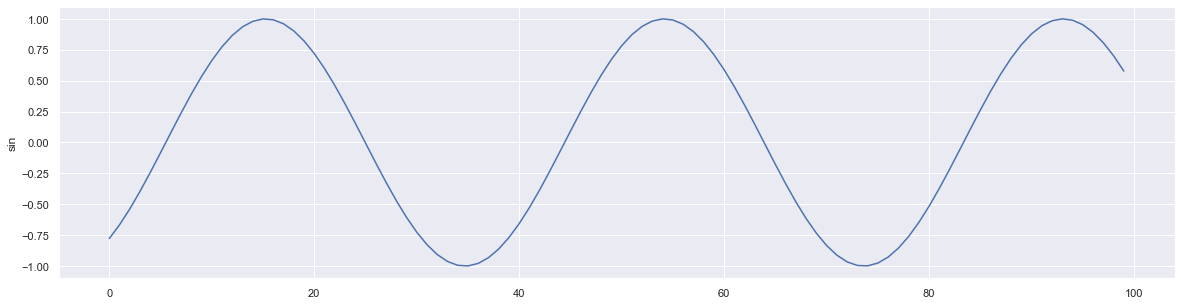

In [18]:
sns.lineplot(data=df['sin'][:100])


<AxesSubplot:ylabel='cos'>

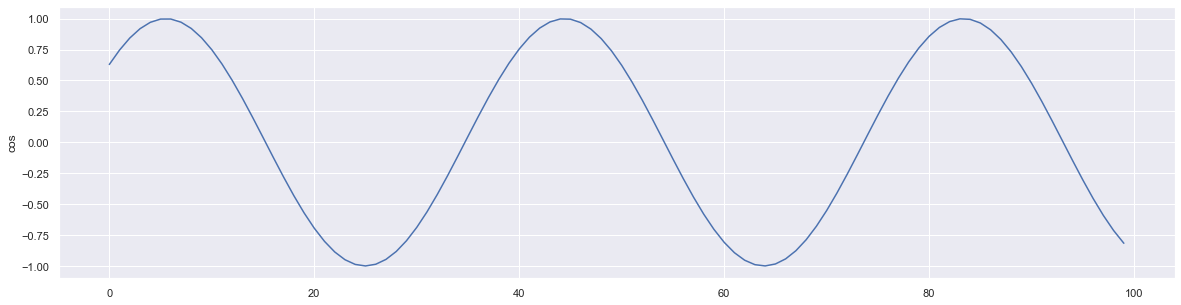

In [19]:
sns.lineplot(data=df['cos'][:100])

<AxesSubplot:xlabel='sin', ylabel='cos'>

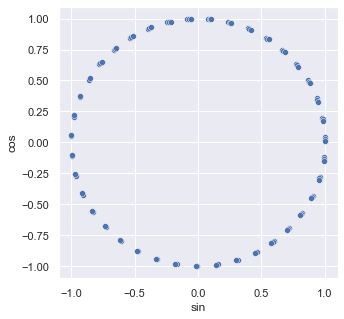

In [20]:
sns.set(rc={'figure.figsize':(5,5)})
sns.scatterplot(data=df[['sin', 'cos']][:100], x="sin", y="cos")

## Geographical feature transformation

Geo location can be presented in many different ways, but here lets see the most common option with latitude and longitude, given that in the dataset it is presented in latitute N/S and longitude E/W form:

In [21]:
# convert to stantand latitude & longitude
df['lat'] = df['Latitude'].apply(lambda coord: float(coord.replace('N', '')) if 'N' in coord else -float(coord.replace('S', '')))
df['lng'] = df['Longitude'].apply(lambda coord: float(coord.replace('E', '')) if 'E' in coord else -float(coord.replace('W', '')))

# transform to UTM form
myProj = Proj("+proj=utm +zone=23K, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
df['UTMx'], df['UTMy'] = myProj(df['lng'].values, df['lat'].values)

# transform to Web Mercator EPSG:3857
df['EPSG_3857'] = list(zip(df.lat,df.lng))
TRAN_4326_TO_3857 = Transformer.from_crs("EPSG:4326", "EPSG:3857")
df['EPSG_3857'] = df['EPSG_3857'].apply(lambda i: TRAN_4326_TO_3857.transform(i[0], i[1]))
df['lat_3857'], df['lng_3857'] = zip(*list(df['EPSG_3857']))

# obtain adress
# get adress/postcode/name info via GeoPy ****

# transform to polygones/points
# use GDAL osgeo package


**** more info could be found [here](https://towardsdatascience.com/reverse-geocoding-in-python-a915acf29eb6)

## Text transformation

For example in the observed dataset there is a Country column cosists of country names, though those names are not all in english language (e.g. Côte D'Ivoire country name) and you might want to have all your records in one language:

In [22]:
# translate all countries to english
translator = google_translator() 
countries_en = [translator.translate(c)[:-1] for c in np.unique(df['Country'])]
countries_en = dict(ChainMap(*[{c1:c2} for c1,c2 in zip(np.unique(df['Country']),countries_en) if c1!=c2]))
df['country_en'] = df['Country'].replace(countries_en)

# convert to numeric column (labelencoding)
df['country_code'] =  df['country_en'].astype('category').cat.codes

# bigger texts can be transformed in many ways
# use NLP for your purposes

In [23]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,date,AverageTemperature_int,AverageTemperature_rounded,...,cos,lat,lng,UTMx,UTMy,EPSG_3857,lat_3857,lng_3857,country_en,country_code
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-01-01,26,26.7,...,6.293204e-01,5.63,-3.23,5.592044e+06,8.344627e+05,"(-359561.9552622736, 627739.7302061038)",-3.595620e+05,6.277397e+05,Ivory Coast,21
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-02-01,27,27.4,...,7.460574e-01,5.63,-3.23,5.592044e+06,8.344627e+05,"(-359561.9552622736, 627739.7302061038)",-3.595620e+05,6.277397e+05,Ivory Coast,21
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-03-01,28,28.1,...,8.433914e-01,5.63,-3.23,5.592044e+06,8.344627e+05,"(-359561.9552622736, 627739.7302061038)",-3.595620e+05,6.277397e+05,Ivory Coast,21
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-04-01,26,26.1,...,9.187912e-01,5.63,-3.23,5.592044e+06,8.344627e+05,"(-359561.9552622736, 627739.7302061038)",-3.595620e+05,6.277397e+05,Ivory Coast,21
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-05-01,25,25.4,...,9.702957e-01,5.63,-3.23,5.592044e+06,8.344627e+05,"(-359561.9552622736, 627739.7302061038)",-3.595620e+05,6.277397e+05,Ivory Coast,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E,2013-05-01,18,19.0,...,6.123234e-17,34.56,108.97,2.915961e+06,1.584701e+07,"(12130484.91174302, 4104246.5068497644)",1.213048e+07,4.104247e+06,China,8
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E,2013-06-01,23,23.5,...,-1.607426e-01,34.56,108.97,2.915961e+06,1.584701e+07,"(12130484.91174302, 4104246.5068497644)",1.213048e+07,4.104247e+06,China,8
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E,2013-07-01,25,25.3,...,-3.173047e-01,34.56,108.97,2.915961e+06,1.584701e+07,"(12130484.91174302, 4104246.5068497644)",1.213048e+07,4.104247e+06,China,8
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E,2013-08-01,24,24.5,...,-4.656145e-01,34.56,108.97,2.915961e+06,1.584701e+07,"(12130484.91174302, 4104246.5068497644)",1.213048e+07,4.104247e+06,China,8
